# ERDDAP Prawler Tools - find and compare with fixed depth TimeSeries Instruments

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import xarray as xa

import datetime
import EcoFOCIpy.io.erddap as erddap

In [2]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8082/erddap'
dataset_name = 'erddap_24bspr2a_prawler'
e = ERDDAP(server=server_url,
          protocol='tabledap',
          response='csv')

e.dataset_id=dataset_name

pdf = e.to_pandas(
            index_col='time (UTC)',
            parse_dates=True,
            skiprows=(1,)  # units information can be dropped.
        )
pdf.columns = [x.split()[0] for x in pdf.columns]

In [59]:
spdf = pdf[(pdf.depth >10.5) & (pdf.depth < 21.5)].reset_index()

In [60]:
pdf_14m = spdf[(spdf.depth <11.5)].groupby('profileNum').mean(numeric_only=True)
pdf_22m = spdf[(spdf.depth >20.5)].groupby('profileNum').mean(numeric_only=True)
profile_time = spdf.groupby('profileNum').first().reset_index()

In [61]:
pdf_14m = pd.merge(pdf_14m,profile_time[['time (UTC)','profileNum']],right_on='profileNum',left_on='profileNum')
pdf_14m = pdf_14m.set_index('time (UTC)')
pdf_22m = pd.merge(pdf_22m,profile_time[['time (UTC)','profileNum']],right_on='profileNum',left_on='profileNum')
pdf_22m = pdf_22m.set_index('time (UTC)')

## Load timeseries netcdf from final data

In [62]:
s16 = xa.load_dataset('/Users/bell/ecoraid/2023/Moorings/23bs2c/final_data_cf//23bs2c_s16_0022m.nc')
rcm9 = xa.load_dataset('/Users/bell/ecoraid/2023/Moorings/23bs2c/final_data_cf/23bs2c_an9_0014m.nc')

(19844.0, 19981.0)

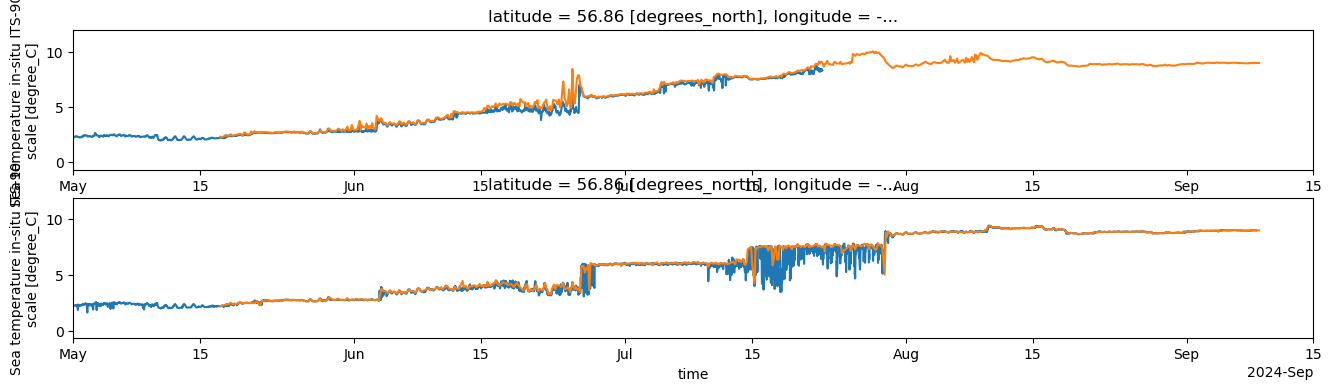

In [63]:
import matplotlib.pyplot as plt
import datetime

fig, ax = plt.subplots(2,figsize=(16, 4))
s16.temperature.plot(ax=ax[1])
rcm9.temperature.plot(ax=ax[0])
ax[0].plot(pdf_14m.index,pdf_14m.Temperature)
ax[1].plot(pdf_22m.index,pdf_22m.Temperature)

ax[0].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])
ax[1].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])

(250.0, 425.0)

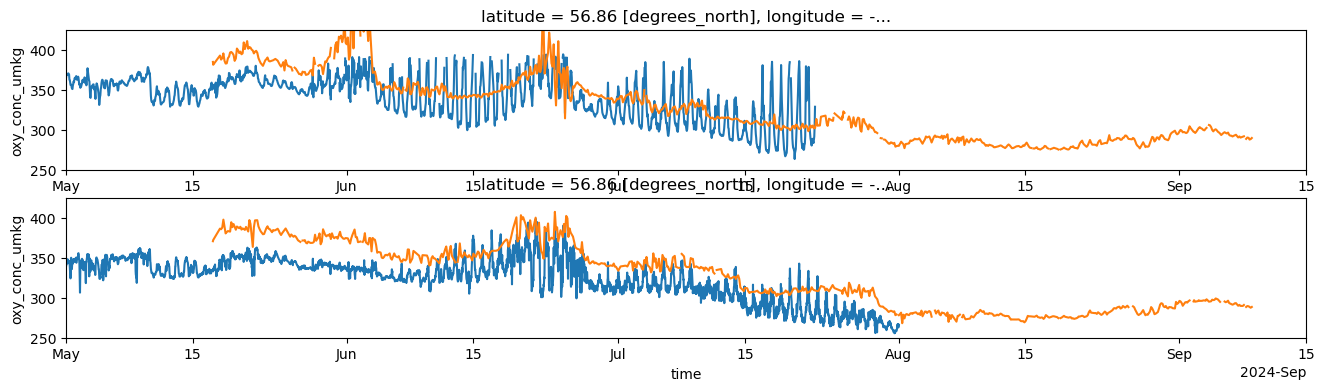

In [64]:
fig, ax = plt.subplots(2,figsize=(16, 4))
s16.oxy_conc_umkg.plot(ax=ax[1])
rcm9.oxy_conc_umkg.plot(ax=ax[0])
ax[0].plot(pdf_14m.index,pdf_14m.Oxy_Conc)
ax[1].plot(pdf_22m.index,pdf_22m.Oxy_Conc)

ax[0].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])
ax[1].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])
ax[0].set_ylim([250,425])
ax[1].set_ylim([250,425])

In [65]:
dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'aq2301',
               'qclevel':'preliminary',
               'concastno':'009'
              }
mid_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8080/erddap",
               'cruiseid':'dy2407',
               'qclevel':'final',
               'concastno':'001'
              }

rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2410',
               'qclevel':'preliminary',
               'concastno':'009'
              }
               
depcast = erddap.erddapCTDretrieve(**dep_details)
# midcast = erddap.erddapCTDretrieve(**mid_details)
reccast = erddap.erddapCTDretrieve(**rec_details)

In [66]:
#drop units from names
depcast.columns = [x.split()[0] for x in depcast.columns]
# midcast.columns = [x.split()[0] for x in midcast.columns]
reccast.columns = [x.split()[0] for x in reccast.columns]

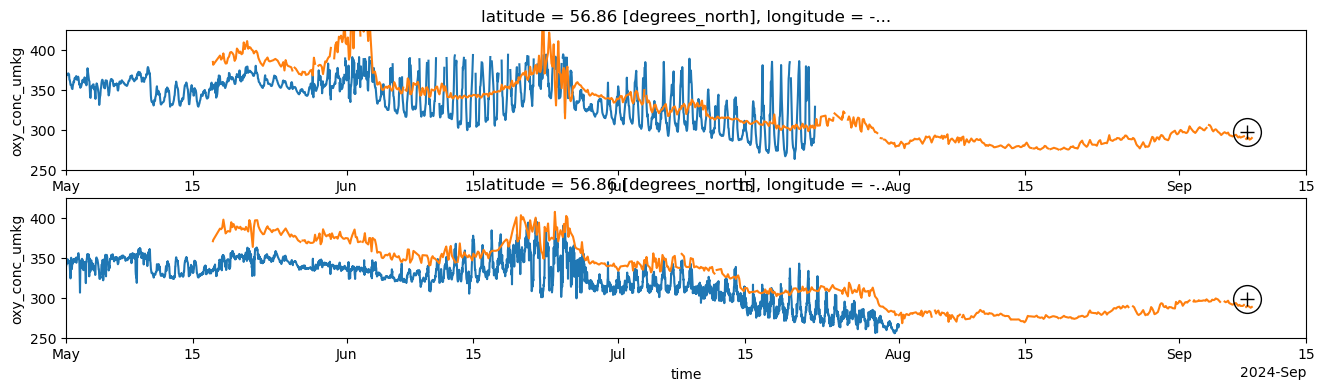

In [67]:
fig, ax = plt.subplots(2,figsize=(16, 4))
s16.oxy_conc_umkg.plot(ax=ax[1])
rcm9.oxy_conc_umkg.plot(ax=ax[0])
ax[0].plot(pdf_14m.index,pdf_14m.Oxy_Conc)
ax[1].plot(pdf_22m.index,pdf_22m.Oxy_Conc)

ax[0].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])
ax[1].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])
ax[0].set_ylim([250,425])
ax[1].set_ylim([250,425])

ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == 22]['time']),
        reccast[reccast['pressure'] == 14]['O_65'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == 22]['time']),
        reccast[reccast['pressure'] == 14]['O_65'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == 22]['time']),
        reccast[reccast['pressure'] == 22]['O_65'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == 22]['time']),
        reccast[reccast['pressure'] == 22]['O_65'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

In [80]:
pdf_14m_hourly = pdf_14m.resample('3H').mean().resample('1H').interpolate()

(19844.0, 19981.0)

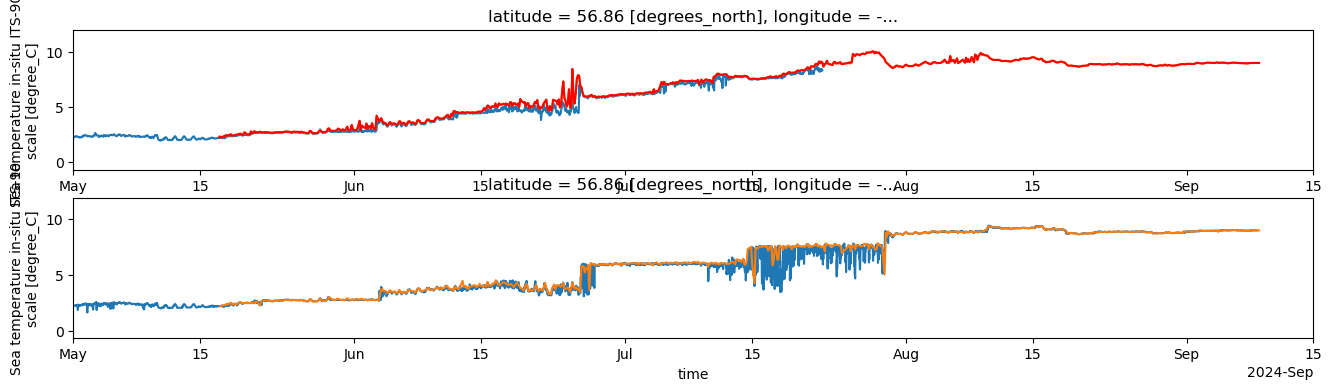

In [81]:
fig, ax = plt.subplots(2,figsize=(16, 4))
s16.temperature.plot(ax=ax[1])
rcm9.temperature.plot(ax=ax[0])
ax[0].plot(pdf_14m.index,pdf_14m.Temperature)
ax[0].plot(pdf_14m_hourly.index,
           pdf_14m_hourly.Temperature,'r')
ax[1].plot(pdf_22m.index,pdf_22m.Temperature)

ax[0].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])
ax[1].set_xlim([datetime.date(2024,5,1),datetime.date(2024,9,15)])

In [82]:
pdf_14m_hourly[['Temperature','Salinity','depth','Oxy_Conc','Oxy_Sat']].to_csv('24bspr2a_11m_oxy.csv')

In [76]:
pdf_14m_hourly.columns

Index(['profileNum', 'longitude', 'latitude', 'depth', 'Temperature',
       'Conductivity', 'Oxy_Temperature', 'Salinity', 'Salinity_aandT',
       'Chlorophyll', 'Turbidity', 'Oxy_Conc_aandT', 'Oxy_Conc', 'Oxy_Sat'],
      dtype='object')